In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from NEExT.collections import EgonetCollection
from NEExT.io import GraphIO
from NEExT.datasets import GraphDataset

%reload_ext autoreload
%autoreload 2

In [3]:
from NEExT.outliers.benchmark_utils.data_loading import load_abcdo_data, load_pygod_data
from NEExT.outliers.benchmark_utils.embed import build_features
from NEExT.outliers.benchmark_utils.embed import build_embeddings
from NEExT.outliers.benchmark_utils.supervised import supervised_eval

graph_io = GraphIO()
hide_frac = {0: 0.8, 1: 0.8}
k_hop = 1

# edges_df, mapping_df, features_df, ground_truth_df = load_pygod_data(hide_frac=hide_frac)
edges_df, mapping_df, features_df, ground_truth_df = load_abcdo_data(hide_frac=hide_frac)

graph_data = {
    "target": "is_outlier",
    "skip_features": [],
    "feature_list": [],
    # "feature_list": [i for i in features_df.columns[1:-1]],
}

In [4]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
subgraph_collection = EgonetCollection()
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=graph_data["target"],
    egonet_algorithm="k_hop_egonet",
    skip_features=graph_data["skip_features"],
    max_hop_length=k_hop,
)
structural_features, features = build_features(subgraph_collection, feature_vector_length=k_hop, feature_list=graph_data["feature_list"])

In [5]:
embeddings = build_embeddings(
    subgraph_collection,
    structural_features,
    features,
    strategy="structural_embeddings",
    embeddings_dimension=5,
    embeddings_algorithm="approx_wasserstein",
    # approx_wasserstein, wasserstein, sinkhornvectorizer
)
dataset = GraphDataset(subgraph_collection, embeddings, standardize=False)

In [6]:
model = "lgbm"
out_df, score = supervised_eval(model, ground_truth_df, dataset)
score

[I 2025-04-05 15:29:38,522] A new study created in memory with name: no-name-f3f3b3fd-b33a-4699-ab19-6056154be2c7


[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early 

[I 2025-04-05 15:29:43,240] Trial 3 finished with value: 0.828125 and parameters: {'n_estimators': 12, 'min_data_in_leaf': 5, 'num_leaves': 47, 'max_depth': 14, 'class_weight': None, 'learning_rate': 4.861165591431465, 'colsample_bytree': 0.532177580878759}. Best is trial 3 with value: 0.828125.
[I 2025-04-05 15:29:43,289] Trial 4 finished with value: 0.5 and parameters: {'n_estimators': 32, 'min_data_in_leaf': 1, 'num_leaves': 89, 'max_depth': 36, 'class_weight': None, 'learning_rate': 4.703254534522227e-05, 'colsample_bytree': 0.8127934069937841}. Best is trial 3 with value: 0.828125.
[I 2025-04-05 15:29:43,331] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 44, 'min_data_in_leaf': 9, 'num_leaves': 36, 'max_depth': 46, 'class_weight': None, 'learning_rate': 0.0016313604363250391, 'colsample_bytree': 0.4911356697724695}. Best is trial 3 with value: 0.828125.
[I 2025-04-05 15:29:43,340] Trial 5 finished with value: 0.75 and parameters: {'n_estimators': 58, 'min_data_

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Number of positive: 24, number of negative: 96

Training until validation scores don't improve for 5 rounds[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the

[I 2025-04-05 15:29:43,425] Trial 9 finished with value: 0.5 and parameters: {'n_estimators': 74, 'min_data_in_leaf': 1, 'num_leaves': 22, 'max_depth': 12, 'class_weight': None, 'learning_rate': 4.440766719120674e-05, 'colsample_bytree': 0.2823398303727853}. Best is trial 3 with value: 0.828125.
[I 2025-04-05 15:29:43,443] Trial 10 finished with value: 0.5 and parameters: {'n_estimators': 9, 'min_data_in_leaf': 1, 'num_leaves': 95, 'max_depth': 68, 'class_weight': 'balanced', 'learning_rate': 0.08695801821105026, 'colsample_bytree': 0.5137172444366207}. Best is trial 3 with value: 0.828125.
[I 2025-04-05 15:29:43,462] Trial 11 finished with value: 0.5 and parameters: {'n_estimators': 12, 'min_data_in_leaf': 4, 'num_leaves': 100, 'max_depth': 48, 'class_weight': 'balanced', 'learning_rate': 0.00022542270819930483, 'colsample_bytree': 0.8369239068386918}. Best is trial 3 with value: 0.828125.
[I 2025-04-05 15:29:43,501] Trial 12 finished with value: 0.5 and parameters: {'n_estimators': 6

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parame

[I 2025-04-05 15:29:43,725] Trial 14 finished with value: 0.790625 and parameters: {'n_estimators': 55, 'min_data_in_leaf': 6, 'num_leaves': 67, 'max_depth': 100, 'class_weight': None, 'learning_rate': 9.42677952196787, 'colsample_bytree': 0.6209853405385843}. Best is trial 3 with value: 0.828125.
[I 2025-04-05 15:29:43,741] Trial 15 finished with value: 0.846875 and parameters: {'n_estimators': 57, 'min_data_in_leaf': 5, 'num_leaves': 70, 'max_depth': 99, 'class_weight': None, 'learning_rate': 5.6637645965333565, 'colsample_bytree': 0.6489466673037799}. Best is trial 15 with value: 0.846875.
[I 2025-04-05 15:29:43,808] Trial 16 finished with value: 0.80625 and parameters: {'n_estimators': 57, 'min_data_in_leaf': 6, 'num_leaves': 68, 'max_depth': 99, 'class_weight': None, 'learning_rate': 9.963180617719102, 'colsample_bytree': 0.6378040354543064}. Best is trial 15 with value: 0.846875.
[I 2025-04-05 15:29:43,817] Trial 17 finished with value: 0.853125 and parameters: {'n_estimators': 5

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there 

[I 2025-04-05 15:29:43,954] Trial 18 finished with value: 0.7625 and parameters: {'n_estimators': 53, 'min_data_in_leaf': 7, 'num_leaves': 60, 'max_depth': 99, 'class_weight': None, 'learning_rate': 1.5749545754213596, 'colsample_bytree': 0.6509990072057649}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,001] Trial 19 finished with value: 0.740625 and parameters: {'n_estimators': 71, 'min_data_in_leaf': 4, 'num_leaves': 46, 'max_depth': 98, 'class_weight': None, 'learning_rate': 0.7887697354217573, 'colsample_bytree': 0.6067335048703117}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,007] Trial 20 finished with value: 0.653125 and parameters: {'n_estimators': 72, 'min_data_in_leaf': 8, 'num_leaves': 79, 'max_depth': 91, 'class_weight': None, 'learning_rate': 0.6828109676532059, 'colsample_bytree': 0.4036146633179226}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,071] Trial 21 finished with value: 0.71875 and parameters: {'n_estimators': 

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-04-05 15:29:44,183] Trial 22 finished with value: 0.5375 and parameters: {'n_estimators': 69, 'min_data_in_leaf': 3, 'num_leaves': 79, 'max_depth': 84, 'class_weight': None, 'learning_rate': 0.3459313810551583, 'colsample_bytree': 0.38639010992688294}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,249] Trial 23 finished with value: 0.5 and parameters: {'n_estimators': 40, 'min_data_in_leaf': 5, 'num_leaves': 46, 'max_depth': 19, 'class_weight': None, 'learning_rate': 0.14349020688185213, 'colsample_bytree': 0.6963621146577739}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,257] Trial 24 finished with value: 0.5375 and parameters: {'n_estimators': 38, 'min_data_in_leaf': 5, 'num_leaves': 50, 'max_depth': 21, 'class_weight': None, 'learning_rate': 0.15427110404199207, 'colsample_bytree': 0.7026631452080617}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,310] Trial 25 finished with value: 0.5 and parameters: {'n_estimators': 44, 'min

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early 

[I 2025-04-05 15:29:44,461] Trial 26 finished with value: 0.659375 and parameters: {'n_estimators': 42, 'min_data_in_leaf': 5, 'num_leaves': 46, 'max_depth': 20, 'class_weight': None, 'learning_rate': 2.775182132538536, 'colsample_bytree': 0.710323860000737}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,540] Trial 27 finished with value: 0.7625 and parameters: {'n_estimators': 49, 'min_data_in_leaf': 5, 'num_leaves': 48, 'max_depth': 59, 'class_weight': None, 'learning_rate': 2.675617177451854, 'colsample_bytree': 0.5515241091725316}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,556] Trial 28 finished with value: 0.83125 and parameters: {'n_estimators': 64, 'min_data_in_leaf': 3, 'num_leaves': 68, 'max_depth': 65, 'class_weight': None, 'learning_rate': 3.392915688204542, 'colsample_bytree': 0.5412628680660421}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,603] Trial 29 finished with value: 0.84375 and parameters: {'n_estimators': 64, '

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-04-05 15:29:44,756] Trial 30 finished with value: 0.83125 and parameters: {'n_estimators': 29, 'min_data_in_leaf': 3, 'num_leaves': 11, 'max_depth': 60, 'class_weight': 'balanced', 'learning_rate': 3.4637695703104603, 'colsample_bytree': 0.5669091237565321}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,824] Trial 31 finished with value: 0.5 and parameters: {'n_estimators': 32, 'min_data_in_leaf': 3, 'num_leaves': 12, 'max_depth': 38, 'class_weight': 'balanced', 'learning_rate': 0.03660351602933452, 'colsample_bytree': 0.5825547839796072}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:44,869] Trial 32 finished with value: 0.5 and parameters: {'n_estimators': 64, 'min_data_in_leaf': 2, 'num_leaves': 69, 'max_depth': 72, 'class_weight': 'balanced', 'learning_rate': 0.028406787092875755, 'colsample_bytree': 0.7979914489672587}. Best is trial 17 with value: 0.853125.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24,

[I 2025-04-05 15:29:44,938] Trial 33 finished with value: 0.5 and parameters: {'n_estimators': 63, 'min_data_in_leaf': 2, 'num_leaves': 73, 'max_depth': 75, 'class_weight': 'balanced', 'learning_rate': 0.049853365338329673, 'colsample_bytree': 0.7898951218867788}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:45,040] Trial 34 finished with value: 0.653125 and parameters: {'n_estimators': 65, 'min_data_in_leaf': 3, 'num_leaves': 69, 'max_depth': 71, 'class_weight': 'balanced', 'learning_rate': 0.4494716557610154, 'colsample_bytree': 0.7741923965401755}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:45,106] Trial 35 finished with value: 0.565625 and parameters: {'n_estimators': 65, 'min_data_in_leaf': 2, 'num_leaves': 72, 'max_depth': 73, 'class_weight': 'balanced', 'learning_rate': 0.540927112470162, 'colsample_bytree': 0.47014803035600305}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:45,190] Trial 36 finished with value: 0.7375 and parameters: {

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-04-05 15:29:45,213] Trial 37 finished with value: 0.5 and parameters: {'n_estimators': 66, 'min_data_in_leaf': 2, 'num_leaves': 62, 'max_depth': 67, 'class_weight': 'balanced', 'learning_rate': 0.44321340385024016, 'colsample_bytree': 0.44740401144228703}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:45,360] Trial 38 finished with value: 0.853125 and parameters: {'n_estimators': 50, 'min_data_in_leaf': 2, 'num_leaves': 61, 'max_depth': 64, 'class_weight': 'balanced', 'learning_rate': 5.03255889823363, 'colsample_bytree': 0.6609037069534868}. Best is trial 17 with value: 0.853125.
[I 2025-04-05 15:29:45,425] Trial 39 finished with value: 0.85625 and parameters: {'n_estimators': 51, 'min_data_in_leaf': 4, 'num_leaves': 62, 'max_depth': 91, 'class_weight': None, 'learning_rate': 5.308337814540166, 'colsample_bytree': 0.6679368497323618}. Best is trial 39 with value: 0.85625.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-04-05 15:29:45,528] Trial 40 finished with value: 0.73125 and parameters: {'n_estimators': 52, 'min_data_in_leaf': 4, 'num_leaves': 62, 'max_depth': 41, 'class_weight': None, 'learning_rate': 5.390325345535593, 'colsample_bytree': 0.4822711878987671}. Best is trial 39 with value: 0.85625.
[I 2025-04-05 15:29:45,537] Trial 41 finished with value: 0.80625 and parameters: {'n_estimators': 51, 'min_data_in_leaf': 7, 'num_leaves': 87, 'max_depth': 92, 'class_weight': None, 'learning_rate': 5.639488815087857, 'colsample_bytree': 0.5286300315398395}. Best is trial 39 with value: 0.85625.
[I 2025-04-05 15:29:45,704] Trial 42 finished with value: 0.728125 and parameters: {'n_estimators': 52, 'min_data_in_leaf': 7, 'num_leaves': 55, 'max_depth': 91, 'class_weight': 'balanced', 'learning_rate': 1.2885154161067554, 'colsample_bytree': 0.894439763028712}. Best is trial 39 with value: 0.85625.


[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-04-05 15:29:45,730] Trial 43 finished with value: 0.771875 and parameters: {'n_estimators': 51, 'min_data_in_leaf': 7, 'num_leaves': 86, 'max_depth': 92, 'class_weight': None, 'learning_rate': 1.3123897353868421, 'colsample_bytree': 0.9082298817046854}. Best is trial 39 with value: 0.85625.
[I 2025-04-05 15:29:45,817] Trial 44 finished with value: 0.7375 and parameters: {'n_estimators': 58, 'min_data_in_leaf': 6, 'num_leaves': 55, 'max_depth': 93, 'class_weight': 'balanced', 'learning_rate': 1.5306039518623613, 'colsample_bytree': 0.6668146521987451}. Best is trial 39 with value: 0.85625.
[I 2025-04-05 15:29:45,870] Trial 45 finished with value: 0.7375 and parameters: {'n_estimators': 58, 'min_data_in_leaf': 4, 'num_leaves': 55, 'max_depth': 80, 'class_weight': 'balanced', 'learning_rate': 1.3773996875231653, 'colsample_bytree': 0.6773634633784698}. Best is trial 39 with value: 0.85625.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-04-05 15:29:46,010] Trial 46 finished with value: 0.759375 and parameters: {'n_estimators': 59, 'min_data_in_leaf': 4, 'num_leaves': 55, 'max_depth': 79, 'class_weight': 'balanced', 'learning_rate': 1.7196498864293945, 'colsample_bytree': 0.66764696977709}. Best is trial 39 with value: 0.85625.
[I 2025-04-05 15:29:46,018] Trial 47 finished with value: 0.80625 and parameters: {'n_estimators': 59, 'min_data_in_leaf': 4, 'num_leaves': 37, 'max_depth': 80, 'class_weight': 'balanced', 'learning_rate': 5.235096791362914, 'colsample_bytree': 0.7511981207361442}. Best is trial 39 with value: 0.85625.
[I 2025-04-05 15:29:46,065] Trial 48 finished with value: 0.85625 and parameters: {'n_estimators': 59, 'min_data_in_leaf': 4, 'num_leaves': 75, 'max_depth': 82, 'class_weight': 'balanced', 'learning_rate': 5.376904325849134, 'colsample_bytree': 0.5873360229178433}. Best is trial 39 with value: 0.85625.
[I 2025-04-05 15:29:46,071] Trial 49 finished with value: 0.740625 and parameters: {'n_e

ve the overhead.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

0.8437500000000001

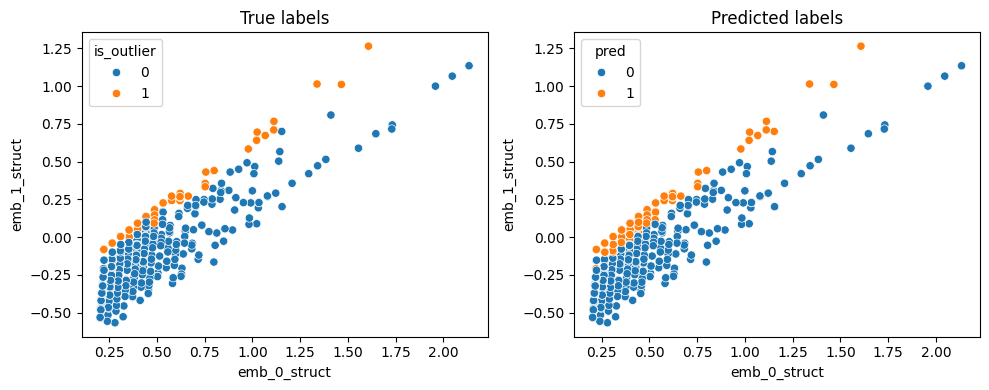

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=out_df["pred"], ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()